In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Aplanar la salida para las capas completamente conectadas
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# Crear una instancia del modelo (asegúrate de que coincida con la arquitectura)
modelo = CNNModel() 

# Cargar el estado del modelo desde el archivo
modelo.load_state_dict(torch.load('modelo_entrenado.pth'))

# Coloca el modelo en modo de evaluación
modelo.eval()

CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [4]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [5]:
# Define una función para realizar la predicción
def predecir_clase(imagen, modelo, clases):
    # Aplica las transformaciones de datos a la imagen
    imagen = data_transform(imagen)
    imagen = imagen.unsqueeze(0)  # Agrega una dimensión adicional para que coincida con la entrada del modelo

    output = modelo(imagen)

    _, predicted = torch.max(output, 1)

    # Obtiene el nombre de la clase predicha
    nombre_clase = clases[predicted.item()]

    # Convierte la imagen de nuevo a un formato adecuado para visualización
    imagen_visualizacion = imagen.squeeze().permute(1, 2, 0).cpu().numpy()

    return nombre_clase, imagen_visualizacion

In [6]:
# Define las clases
clases = ['Glioma', 'Meningioma', 'Pituitary tumor']

In [7]:
# Lista de rutas de archivo de imágenes
rutas_de_imagenes = [
    'DatasetTumoresCerebrales/test/Meningioma/17.png',
    'DatasetTumoresCerebrales/test/Glioma/717.png',
    'DatasetTumoresCerebrales/test/Pituitary tumor/926.png'
]

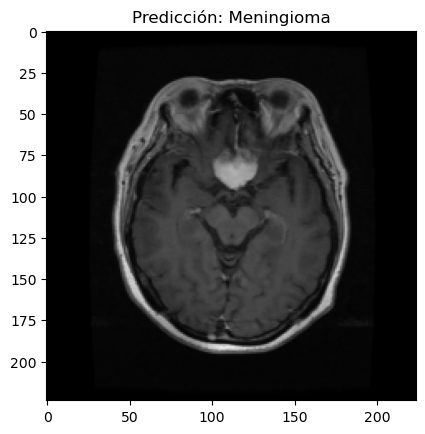

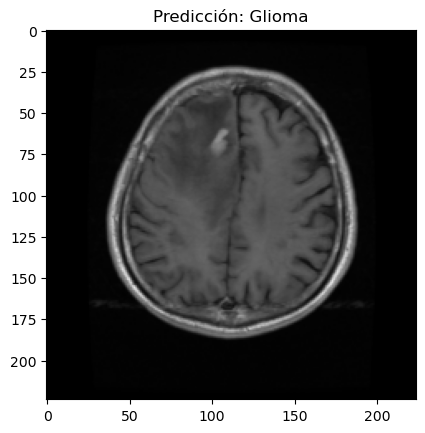

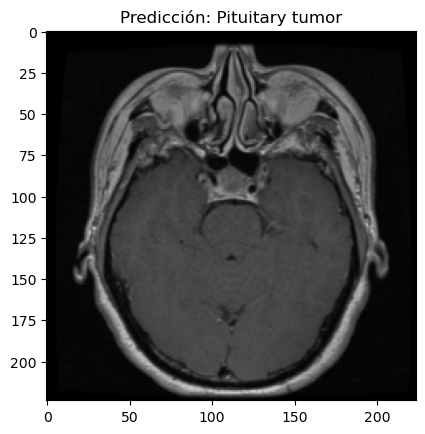

In [8]:
# Itera a través de las imágenes y realiza predicciones
for ruta in rutas_de_imagenes:
    imagen = Image.open(ruta).convert('RGB')
    nombre_clase, imagen_visualizacion = predecir_clase(imagen, modelo, clases)

    # Muestra la imagen junto con la etiqueta predicha
    plt.imshow(imagen_visualizacion)
    plt.title(f'Predicción: {nombre_clase}')
    plt.show()